In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
cd ..

/Users/odatakuma/cmu/FleetAI


In [3]:
data_path = 'analytics/data/taxi_trips/taxi_tripdata_2016-05.csv'

## 1. Geohash all trip records

Final preprocess steps

In [5]:
df = pd.read_csv(data_path, index_col='request_id')

from analytics.preprocess import geohashing
df['pickup_geohash'] = geohashing(df[['pickup_latitude', 'pickup_longitude']])
df['dropoff_geohash'] = geohashing(df[['dropoff_latitude', 'dropoff_longitude']])
df.head()

,date,dayofweek,dropoff_latitude,dropoff_longitude,hour,minute,pickup_latitude,pickup_longitude,second,trip_distance,trip_time,great_circle_distance,pickup_geohash,dropoff_geohash,pickup_zone,dropoff_zone
request_id,,,,,,,,,,,,,,,,
0,1,6,40.730099,-73.983986,0,0,40.768040,-73.985901,0,3.60,17.516667,4221,dr5rumt,dr5rsqw,172,55
1,1,6,40.744633,-73.980995,0,0,40.741573,-73.993073,0,1.09,7.016667,1072,dr5ru0z,dr5ru92,255,79
2,1,6,40.733002,-74.002258,0,0,40.684601,-73.991943,0,4.21,19.783333,5451,dr5rkq2,dr5rsp1,74,111
3,1,6,40.765469,-73.975700,0,0,40.744751,-73.991577,0,1.68,7.516667,2663,dr5ru32,dr5ruth,172,197
4,1,6,40.737564,-73.997498,0,0,40.740192,-74.005280,0,0.56,6.650000,717,dr5rgbx,dr5ru0h,254,255


In [6]:
df.to_csv(data_path)

## Create geohash table

In [4]:
df = pd.read_csv(data_path, usecols=['pickup_geohash'])
pickup = df.groupby(['pickup_geohash']).pickup_geohash.count()
pickup.head()

pickup_geohash
dr5qgxz    1
dr5qgz2    1
dr5qgz5    3
dr5qgz7    1
dr5qgz8    1
Name: pickup_geohash, dtype: int64

In [5]:
df = pd.read_csv(data_path, usecols=['dropoff_geohash'])
dropoff = df.groupby(['dropoff_geohash']).dropoff_geohash.count()
dropoff.head()

dropoff_geohash
dr5qgru    1
dr5qgrv    2
dr5qgry    1
dr5qgxm    1
dr5qgxs    2
Name: dropoff_geohash, dtype: int64

In [6]:
import Geohash

demand = pd.concat([pickup, dropoff], axis=1).fillna(0)
demand = demand.rename(columns={
    'pickup_geohash':'total_pickup',
    'dropoff_geohash':'total_dropoff'
})
geolats = []
geolons = []
for s in demand.index:
    lat, lon, _, _ = Geohash.decode_exactly(s)
    geolats.append(float(lat))
    geolons.append(float(lon))
demand['lat'] = geolats
demand['lon'] = geolons
demand = demand.reset_index().rename(columns={'index':'geohash'})
demand.head()

,geohash,total_pickup,total_dropoff,lat,lon
0,dr5qgru,0,1,40.604782,-74.030685
1,dr5qgrv,0,2,40.604782,-74.029312
2,dr5qgry,0,1,40.604782,-74.027939
3,dr5qgxm,0,1,40.602036,-74.018326
4,dr5qgxs,0,2,40.603409,-74.019699


In [7]:
demand.shape

(28734, 5)

In [8]:
demand = demand[(demand.total_pickup>5)|(demand.total_dropoff>5)]
demand.shape

(21700, 5)

## 2. Analyze # of pickup/dropoff by zones

In [9]:
from engine.mapper.geohelper import plot_overmap
import geopandas as gpd

nyc = gpd.read_file("analytics/data/taxi_zones/taxi_zones.shp").to_crs('+proj=latlon')
nyc = nyc[(nyc.borough != 'EWR')&(nyc.borough != 'Staten Island')]

In [10]:
import shapely
import rtree

def assign_zone(loc, gdf):
    df = gpd.GeoDataFrame(loc.copy(), crs="+proj=latlon")
    df["geometry"] = [shapely.geometry.Point(lon, lat)for lat, lon in loc.values]
    df = gpd.sjoin(df, gdf[["geometry"]], how="inner", op="within")    
    return df.index_right

In [11]:
demand['taxi_zone'] = assign_zone(demand[['lat', 'lon']], nyc)
demand = demand.dropna()
demand.head()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone
7,dr5qgxx,0,8,40.603409,-74.015579,10
8,dr5qgxy,0,8,40.604782,-74.016953,10
9,dr5qgxz,1,9,40.604782,-74.015579,10
14,dr5qgz7,1,15,40.602036,-74.010086,10
15,dr5qgz8,1,7,40.603409,-74.014206,10


## 3. Remove taxi zones with low pickup/dropoff

In [12]:
demand_by_zone = demand.groupby(['taxi_zone'])[['total_pickup', 'total_dropoff']].sum()
demand_by_zone.shape

(227, 2)

In [13]:
demand_by_zone = demand_by_zone[
    (demand_by_zone.total_pickup>100)
    | (demand_by_zone.total_dropoff>100)]
demand_by_zone.shape

(221, 2)

In [14]:
nyc['total_pickup'] = np.sqrt(demand_by_zone.total_pickup)
nyc['total_dropoff'] = np.sqrt(demand_by_zone.total_dropoff)

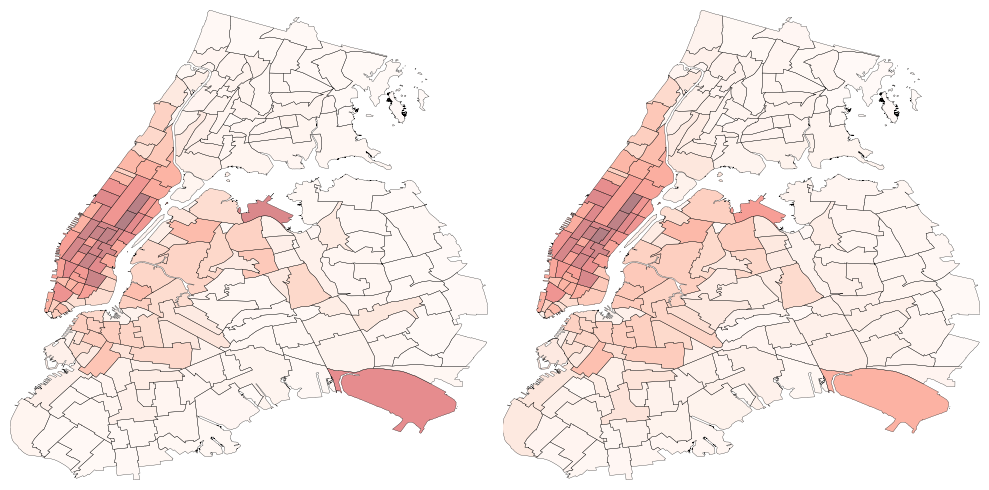

In [32]:
plt.clf()
fig = plt.figure(figsize=(10, 5), dpi=10)
ax1 = fig.add_subplot(121, axisbg='w', frame_on=False)
ax1.set_xticks([])
ax1.set_yticks([])
nyc.dropna().plot(column='total_pickup', cmap="Reds", axes=ax1, linewidth=0.2)
ax2 = fig.add_subplot(122, axisbg='w', frame_on=False)
ax2.set_xticks([])
ax2.set_yticks([])
nyc.dropna().plot(column='total_dropoff', cmap="Reds", axes=ax2, linewidth=0.2)
plt.tight_layout();

In [15]:
taxi_zones = demand_by_zone.index
demand = demand[[zone in taxi_zones for zone in demand.taxi_zone]]

In [16]:
demand.to_csv('analytics/data/geohash.csv', index=False)

## 4. Tag taxi zone to all trip records

In [40]:
zones = pd.read_csv("analytics/data/geohash.csv")
hash2zone = zones.set_index('geohash').taxi_zone.astype(int).to_dict()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone
0,dr5qgxx,0,8,40.603409,-74.015579,10
1,dr5qgxy,0,8,40.604782,-74.016953,10
2,dr5qgxz,1,9,40.604782,-74.015579,10
3,dr5qgz7,1,15,40.602036,-74.010086,10
4,dr5qgz8,1,7,40.603409,-74.014206,10


In [43]:
df = pd.read_csv(data_path,
                 usecols=[
                     'pickup_geohash',
                     'dropoff_geohash'
                 ])
df.head()

,pickup_geohash,dropoff_geohash
0,dr5rumt,dr5rsqw
1,dr5ru0z,dr5ru92
2,dr5rkq2,dr5rsp1
3,dr5ru32,dr5ruth
4,dr5rgbx,dr5ru0h


In [44]:
%%time
pickup_zone = df.pickup_geohash.map(lambda x: hash2zone.get(x, -1))

CPU times: user 8.53 s, sys: 258 ms, total: 8.79 s
Wall time: 9.02 s


In [45]:
%%time
dropoff_zone = df.dropoff_geohash.map(lambda x: hash2zone.get(x, -1))

CPU times: user 7.75 s, sys: 191 ms, total: 7.94 s
Wall time: 8 s


In [46]:
df = pd.read_csv(data_path)
df['pickup_zone'] = pickup_zone
df['dropoff_zone'] = dropoff_zone
df.head()

,request_id,date,dayofweek,dropoff_latitude,dropoff_longitude,hour,minute,pickup_latitude,pickup_longitude,second,trip_distance,trip_time,great_circle_distance,pickup_geohash,dropoff_geohash,pickup_zone,dropoff_zone
0,0,1,6,40.730099,-73.983986,0,0,40.768040,-73.985901,0,3.60,17.516667,4221,dr5rumt,dr5rsqw,47,78
1,1,1,6,40.744633,-73.980995,0,0,40.741573,-73.993073,0,1.09,7.016667,1072,dr5ru0z,dr5ru92,89,169
2,2,1,6,40.733002,-74.002258,0,0,40.684601,-73.991943,0,4.21,19.783333,5451,dr5rkq2,dr5rsp1,24,248
3,3,1,6,40.765469,-73.975700,0,0,40.744751,-73.991577,0,1.68,7.516667,2663,dr5ru32,dr5ruth,89,162
4,4,1,6,40.737564,-73.997498,0,0,40.740192,-74.005280,0,0.56,6.650000,717,dr5rgbx,dr5ru0h,67,89


In [47]:
df.to_csv(data_path, index=False)

## 4. Apply map-matching and aggregation

In [18]:
import cPickle as pickle
path = 'engine/data/nyc_network_graph.pkl'
with open(path, 'r') as f:
    G = pickle.load(f)

In [19]:
import engine.mapper.geohelper as gh
from engine.mapper.pathgenerator import PathGenerator
path_generator = PathGenerator(G)

In [20]:
import Geohash

zones['mlat'] = 0
zones['mlon'] = 0
zones['mgeohash'] = zones.geohash
for i, (lat, lon) in zones[['lat', 'lon']].iterrows():
    ntry = 0
    r = 0.0015
    while 1:
        try:
            mlat, mlon = path_generator.mm_convert((lat, lon), georange=r)
            break
        except:
            if ntry == 2:
                raise
            r *= 2
            ntry += 1
    zones.loc[i, ['mlat', 'mlon']] = mlat, mlon
    zones.loc[i, 'mgeohash'] = Geohash.encode(mlat, mlon, 7)
zones.head()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone,mlat,mlon,mgeohash
0,dr5qgxx,0,8,40.603409,-74.015579,10,40.603358,-74.015682,dr5qgxx
1,dr5qgxy,0,8,40.604782,-74.016953,10,40.604832,-74.017029,dr5qgxy
2,dr5qgxz,1,9,40.604782,-74.015579,10,40.604637,-74.015335,dr5qgxz
3,dr5qgz7,1,15,40.602036,-74.010086,10,40.602178,-74.010322,dr5qgz7
4,dr5qgz8,1,7,40.603409,-74.014206,10,40.603474,-74.014180,dr5qgz8


In [21]:
zones.to_csv("analytics/data/geohash.csv", index=False)
g2mm = zones.set_index('geohash')[['mlat', 'mlon', 'mgeohash']].to_dict()

In [26]:
df = pd.read_csv(data_path,
                 usecols=[
                     'pickup_geohash',
                     'pickup_zone',
                     'dropoff_geohash',
                     'dropoff_zone'
                 ])

df = df[df.pickup_zone>=0][df.dropoff_zone>=0]

In [33]:
%%time
df['plat'] = df.pickup_geohash.map(lambda x: g2mm['mlat'].get(x, 0))
df['plon'] = df.pickup_geohash.map(lambda x: g2mm['mlon'].get(x, 0))
df['phash'] = df.pickup_geohash.map(lambda x: g2mm['mgeohash'].get(x, 0))

CPU times: user 19.8 s, sys: 560 ms, total: 20.3 s
Wall time: 20.6 s


In [34]:
%%time
df['dlat'] = df.dropoff_geohash.map(lambda x: g2mm['mlat'].get(x, 0))
df['dlon'] = df.dropoff_geohash.map(lambda x: g2mm['mlon'].get(x, 0))
df['dhash'] = df.dropoff_geohash.map(lambda x: g2mm['mgeohash'].get(x, 0))

CPU times: user 20.1 s, sys: 620 ms, total: 20.7 s
Wall time: 21 s


In [35]:
df.head()

,pickup_geohash,dropoff_geohash,pickup_zone,dropoff_zone,plat,plon,phash,dlat,dlon,dhash
0,dr5rumt,dr5rsqw,47,78,40.768249,-73.985475,dr5rumt,40.729667,-73.983788,dr5rsqw
1,dr5ru0z,dr5ru92,89,169,40.742039,-73.993433,dr5ru0z,40.744732,-73.980941,dr5ru92
2,dr5rkq2,dr5rsp1,24,248,40.684367,-73.992064,dr5rkq2,40.732507,-74.001829,dr5rsp1
3,dr5ru32,dr5ruth,89,162,40.745078,-73.992071,dr5ru32,40.765470,-73.975744,dr5ruth
4,dr5rgbx,dr5ru0h,67,89,40.740652,-74.004656,dr5rgbx,40.737793,-73.997871,dr5ru0h


In [63]:
zones = zones[zones.geohash==zones.mgeohash]
hash2zone = zones.set_index('geohash').taxi_zone.astype(int).to_dict()
df['pzone'] = df.phash.map(lambda x: hash2zone.get(x, -1))
df['dzone'] = df.dhash.map(lambda x: hash2zone.get(x, -1))
df.head()

,pickup_geohash,dropoff_geohash,pickup_zone,dropoff_zone,plat,plon,phash,dlat,dlon,dhash,pzone,dzone
0,dr5rumt,dr5rsqw,47,78,40.768249,-73.985475,dr5rumt,40.729667,-73.983788,dr5rsqw,47,78
1,dr5ru0z,dr5ru92,89,169,40.742039,-73.993433,dr5ru0z,40.744732,-73.980941,dr5ru92,89,169
2,dr5rkq2,dr5rsp1,24,248,40.684367,-73.992064,dr5rkq2,40.732507,-74.001829,dr5rsp1,24,248
3,dr5ru32,dr5ruth,89,162,40.745078,-73.992071,dr5ru32,40.765470,-73.975744,dr5ruth,89,162
4,dr5rgbx,dr5ru0h,67,89,40.740652,-74.004656,dr5rgbx,40.737793,-73.997871,dr5ru0h,67,89


In [73]:
df_ = pd.read_csv(data_path, usecols=[
    'date', 'dayofweek', 'hour', 'minute', 'second',
    'trip_distance', 'trip_time', 'pickup_zone', 'dropoff_zone'])
df_ = df_[df_.dropoff_zone>=0][df_.pickup_zone>=0]

In [76]:
df = df.drop(['pickup_zone', 'dropoff_zone', 'pickup_geohash', 'dropoff_geohash'], axis=1)
df_ = pd.concat([df_, df], axis=1, join='inner')
df_.head()

,date,dayofweek,hour,minute,second,trip_distance,trip_time,pickup_zone,dropoff_zone,plat,plon,phash,dlat,dlon,dhash,pzone,dzone
0,1,6,0,0,0,3.60,17.516667,47,78,40.768249,-73.985475,dr5rumt,40.729667,-73.983788,dr5rsqw,47,78
1,1,6,0,0,0,1.09,7.016667,89,169,40.742039,-73.993433,dr5ru0z,40.744732,-73.980941,dr5ru92,89,169
2,1,6,0,0,0,4.21,19.783333,24,248,40.684367,-73.992064,dr5rkq2,40.732507,-74.001829,dr5rsp1,24,248
3,1,6,0,0,0,1.68,7.516667,89,162,40.745078,-73.992071,dr5ru32,40.765470,-73.975744,dr5ruth,89,162
4,1,6,0,0,0,0.56,6.650000,67,89,40.740652,-74.004656,dr5rgbx,40.737793,-73.997871,dr5ru0h,67,89


In [79]:
len(zones)

21020

In [81]:
df_ = df_.drop(['pickup_zone', 'dropoff_zone'], axis=1)
df_ = df_[df_.pzone>=0][df_.dzone>=0]
len(df_.dhash.append(df_.phash).unique())

21020

In [83]:
df_.head()

,date,dayofweek,hour,minute,second,trip_distance,trip_time,plat,plon,phash,dlat,dlon,dhash,pzone,dzone
0,1,6,0,0,0,3.60,17.516667,40.768249,-73.985475,dr5rumt,40.729667,-73.983788,dr5rsqw,47,78
1,1,6,0,0,0,1.09,7.016667,40.742039,-73.993433,dr5ru0z,40.744732,-73.980941,dr5ru92,89,169
2,1,6,0,0,0,4.21,19.783333,40.684367,-73.992064,dr5rkq2,40.732507,-74.001829,dr5rsp1,24,248
3,1,6,0,0,0,1.68,7.516667,40.745078,-73.992071,dr5ru32,40.765470,-73.975744,dr5ruth,89,162
4,1,6,0,0,0,0.56,6.650000,40.740652,-74.004656,dr5rgbx,40.737793,-73.997871,dr5ru0h,67,89


In [84]:
mmdata_path = 'analytics/data/taxi_trips/mmdata_2016-05.csv'
df_.to_csv(mmdata_path, index=False)

## Compute road density

In [4]:
import json
from engine.mapper.osmloader import OsmLoader

osm_path = 'analytics/data/osm/osm_nyc.json'
osm = OsmLoader(osm_path)

# of nodes: 5092898
# of highways: 57803


In [5]:
from engine.mapper import geohelper as gh

G = osm.get_graph(drive=True, road_max_length=100000, seg_max_length=10)
road_locs = [zip(d['lat'], d['lon']) for _, _, d in G.edges_iter(data=True) if d.get('lat')]
road_density = gh.road_density(road_locs)
node_locs =[(d['lat'], d['lon']) for _, d in G.nodes_iter(data=True) if d.get('lat')]
intxn_density = gh.intxn_density(node_locs)

In [6]:
zones = pd.read_csv("analytics/data/geohash.csv")

zones['road_density'] = [road_density[g] for g in zones.geohash]
zones['intxn_density'] = [intxn_density[g] for g in zones.geohash]
zones.head()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone,mlat,mlon,mgeohash,road_density,intxn_density
0,dr5qgxx,0,8,40.603409,-74.015579,10,40.603358,-74.015682,dr5qgxx,56,36
1,dr5qgxy,0,8,40.604782,-74.016953,10,40.604832,-74.017029,dr5qgxy,43,8
2,dr5qgxz,1,9,40.604782,-74.015579,10,40.604637,-74.015335,dr5qgxz,22,0
3,dr5qgz7,1,15,40.602036,-74.010086,10,40.602178,-74.010322,dr5qgz7,28,9
4,dr5qgz8,1,7,40.603409,-74.014206,10,40.603474,-74.014180,dr5qgz8,59,14


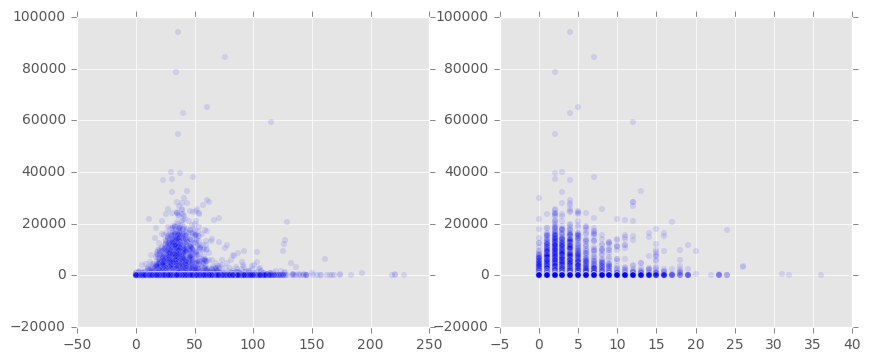

In [8]:
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.scatter(zones.road_density, zones.total_pickup, alpha=0.1)
plt.subplot(122)
plt.scatter(zones.intxn_density, zones.total_pickup, alpha=0.1);

In [9]:
zones.to_csv("analytics/data/geohash.csv", index=False)

## Create Dataset for demand prediction

In [10]:
mmdata_path = 'analytics/data/taxi_trips/mmdata_2016-05.csv'

In [11]:
df = pd.read_csv(mmdata_path,
                 usecols=[
                     'pzone',
                     'dzone',
                     'phash',
                     'hour',
                     'dayofweek',
                     'date'
                 ], dtype={
                     'pzone':np.int16,
                     'dzone':np.int16,
                     'hour':np.int16,
                     'dayofweek':np.int16,
                     'date':np.int16
                 }
                )
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12864484 entries, 0 to 12864483
Data columns (total 6 columns):
date         int16
dayofweek    int16
hour         int16
phash        object
pzone        int16
dzone        int16
dtypes: int16(5), object(1)
memory usage: 319.0+ MB


In [12]:
demand = df.reset_index().groupby(['date', 'dayofweek', 'hour', 'phash']).agg({
    'index':'count'
}).rename(columns={'index':'count'}).reset_index()
demand['datehour'] = (demand.date-1)*24+demand.hour
demand.head()

,date,dayofweek,hour,phash,count,datehour
0,1,6,0,dr5qupn,1,0
1,1,6,0,dr5r56q,1,0
2,1,6,0,dr5r57n,1,0
3,1,6,0,dr5r5mr,1,0
4,1,6,0,dr5r5my,1,0


In [13]:
demand_pivot = demand.pivot(index='datehour', columns='phash', values='count')
demand_pivot = demand_pivot.fillna(0)
demand_pivot.head()

phash,dr5qgz7,dr5qgz8,dr5qgzc,dr5qgze,dr5qgzr,dr5qgzu,dr5qgzw,dr5qup0,dr5qup2,dr5qup3,...,dr7880c,dr78818,dr7881c,dr7881d,dr7881f,dr7881g,dr7882y,dr78842,dr78843,dr78848
datehour,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
del df

In [15]:
demand_pivot['date'] = demand_pivot.index.values/24 + 1
demand_pivot['dayofweek'] = (demand_pivot.date+5)%7
demand_pivot['hour'] = demand_pivot.index.values%24
demand = pd.melt(demand_pivot, id_vars=['date', 'dayofweek', 'hour'])
demand = demand.rename(columns={'phash':'geohash', 'value':'demand'})
demand.head()

,date,dayofweek,hour,geohash,demand
0,1,6,0,dr5qgz7,0
1,1,6,1,dr5qgz7,0
2,1,6,2,dr5qgz7,0
3,1,6,3,dr5qgz7,0
4,1,6,4,dr5qgz7,0


In [16]:
zones = pd.read_csv("analytics/data/geohash.csv",
                    usecols=['geohash', 'lat', 'lon', 'road_density', 'intxn_density'])
zones.head()

,geohash,lat,lon,road_density,intxn_density
0,dr5qgxx,40.603409,-74.015579,56,36
1,dr5qgxy,40.604782,-74.016953,43,8
2,dr5qgxz,40.604782,-74.015579,22,0
3,dr5qgz7,40.602036,-74.010086,28,9
4,dr5qgz8,40.603409,-74.014206,59,14


In [17]:
demand = demand.sort_values(by=['date', 'hour'])
demand = demand.merge(zones, how='left', on='geohash')
demand.head()

,date,dayofweek,hour,geohash,demand,lat,lon,road_density,intxn_density
0,1,6,0,dr5qgz7,0,40.602036,-74.010086,28,9
1,1,6,0,dr5qgz8,0,40.603409,-74.014206,59,14
2,1,6,0,dr5qgzc,0,40.604782,-74.012833,48,2
3,1,6,0,dr5qgze,0,40.603409,-74.010086,40,3
4,1,6,0,dr5qgzr,0,40.602036,-74.004593,26,1


In [18]:
demand.to_csv('analytics/data/demand_dataset.csv', index=False)

In [19]:
del demand

## Create state management table

In [25]:
zones = pd.read_csv("analytics/data/geohash.csv")
zones = zones[zones.geohash==zones.mgeohash]
zones['lat'] = zones.mlat
zones['lon'] = zones.mlon
zones = zones.drop(['mlat', 'mlon', 'mgeohash', 'total_pickup', 'total_dropoff'], axis=1)
zones = zones.set_index('geohash')
zones.head()

,lat,lon,taxi_zone,road_density,intxn_density
geohash,,,,,
dr5qgxx,40.603358,-74.015682,10,56,36
dr5qgxy,40.604832,-74.017029,10,43,8
dr5qgxz,40.604637,-74.015335,10,22,0
dr5qgz7,40.602178,-74.010322,10,28,9
dr5qgz8,40.603474,-74.014180,10,59,14


In [20]:
df = pd.read_csv(mmdata_path,
                 usecols=[
                     'phash',
                     'hour',
                     'date'
                 ])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12864484 entries, 0 to 12864483
Data columns (total 3 columns):
date     int64
hour     int64
phash    object
dtypes: int64(2), object(1)
memory usage: 392.6+ MB


In [21]:
n = df.date.max()
df = df[df.hour==23].groupby('phash')['hour'].count()
df = df/float(n)
df.head()

phash
dr5qup2    0.032258
dr5qupd    0.032258
dr5qur1    0.032258
dr5quxv    0.032258
dr5quxz    0.032258
Name: hour, dtype: float64

In [26]:
zones['latest_demand'] = df
zones = zones.fillna(0)
zones.head()

,lat,lon,taxi_zone,road_density,intxn_density,latest_demand
geohash,,,,,,
dr5qgxx,40.603358,-74.015682,10,56,36,0
dr5qgxy,40.604832,-74.017029,10,43,8,0
dr5qgxz,40.604637,-74.015335,10,22,0,0
dr5qgz7,40.602178,-74.010322,10,28,9,0
dr5qgz8,40.603474,-74.014180,10,59,14,0


In [28]:
zones.to_csv('engine/data/zones.csv')

## Create a OD distance table

In [36]:
zones = pd.read_csv('engine/data/zones.csv', usecols=['lat', 'lon', 'taxi_zone'])
zones.head()

,lat,lon,taxi_zone
0,40.603358,-74.015682,10
1,40.604832,-74.017029,10
2,40.604637,-74.015335,10
3,40.602178,-74.010322,10
4,40.603474,-74.014180,10


In [37]:
zones = zones.groupby('taxi_zone').mean()
zones.head()

,lat,lon
taxi_zone,,
2,40.865465,-73.849574
3,40.724116,-73.977340
6,40.761576,-73.919734
7,40.778363,-73.922796
8,40.753302,-73.788666


In [38]:
import cPickle as pickle
path = 'engine/data/nyc_network_graph.pkl'
with open(path, 'r') as f:
    G = pickle.load(f)

In [39]:
from engine.mapper.pathgenerator import PathGenerator

path_generator = PathGenerator(G)

In [40]:
%%time
OD = zones.copy()
zone_index = map(int, zones.index)
for j in zone_index:
    print j
    OD[j] = 0
    for i in zone_index:
        if i < j:
            OD.loc[i, j] = OD.loc[j, i]
        else:
            try:
                su, sv, sd = path_generator.map_match(zones.loc[i], geo_range=0.0025)
                tu, tv, td = path_generator.map_match(zones.loc[j], geo_range=0.0025)
                _, distance = path_generator.shortest_path(su, tu)
                OD.loc[i, j] = distance
            except:
                print 'ERROR: (%d, %d)' %(i, j)
                OD.loc[i, j] = -1
                continue

2
3
6
7
8
9
10
11
12
13
14
15
16
17
19
20
21
23
24
25
27
30
31
32
33
34
35
36
38
39
40
41
42
44
45
46
47
48
49
50
51
52
53
55
56
57
58
59
60
61
62
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
84
86
87
88
89
90
91
92
93
94
95
96
97
99
101
105
106
110
111
112
113
115
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
150
151
152
154
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
172
173
174
176
177
178
179
180
181
182
183
184
185
187
188
189
190
191
192
193
194
195
196
197
199
201
204
206
207
208
210
211
212
214
215
216
217
218
219
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
245
246
247
248
249
251
252
253
254
255
256
257
258
259
260
261
262
CPU times: user 51min 56s, sys: 38.7 s, total: 52min 34s
Wall time: 52min 38s


In [41]:
OD.head()

,lat,lon,2,3,6,7,8,9,10,11,...,253,254,255,256,257,258,259,260,261,262
taxi_zone,,,,,,,,,,,,,,,,,,,,,
2,40.865465,-73.849574,0.000000,20799.128906,15446.339844,15167.070312,15117.468750,23334.265625,36059.571289,24689.609375,...,2610.078125,21771.582031,22743.519531,31399.468750,23335.391602,4111.015625,18241.441406,24225.933594,14346.156250,14337.835938
3,40.724116,-73.977340,20799.128906,0.000000,9414.384766,10495.150391,19848.027344,19729.890625,16415.262695,4855.984375,...,22364.121094,5130.453125,3809.984375,11755.160156,14106.474609,23465.496094,9851.583984,4392.308594,6749.441406,7089.560547
6,40.761576,-73.919734,15446.339844,9414.384766,0.000000,2289.507812,12145.718750,14986.389648,21298.937500,12766.773438,...,16444.347656,6792.914062,7749.289062,16351.380859,11360.564453,17945.285156,2840.789062,12303.097656,7572.578125,7159.765625
7,40.778363,-73.922796,15167.070312,10495.150391,2289.507812,0.000000,12723.703125,16591.932617,22651.191406,13809.660156,...,16378.355469,7914.136719,8886.074219,17703.634766,12966.107422,17879.292969,4973.554688,13345.984375,8995.222656,8459.695312
8,40.753302,-73.788666,15117.468750,19848.027344,12145.718750,12723.703125,0.000000,9516.761719,28464.097656,22629.976562,...,17266.940804,16300.207031,16801.687500,23527.978516,11182.792969,18533.253304,10573.660156,22166.300781,18599.222656,18230.886719


In [42]:
OD.to_csv('engine/data/OD_distance.csv')